# Explore ULS BGEP

In [1]:
# Read .txt each year
# Clean
#      remove when not enough data (less than 1/2 ?)
# ... 
# Convert to SIT (draft*1.1xx)
# Daily average as netcdf

## Read .txt yearly file

In [2]:
import scipy.io
import h5py
from glob import glob
import numpy as np
import xarray as xr
import datetime
import re
import matplotlib.pyplot as plt

from src.utils import save_name

In [405]:
# read on year
year = 2006

# globglob the file
# can be 5min or 10min average

idir = f'/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_NPEO/{year}/ULS/'
ifile = glob(f'{idir}Mooring*{year}*min*.txt')[0]

In [406]:
# need to identify if 5 or 10 min ? for later

In [407]:
enconding = 'utf-8'
if year == 2006 or year == 2008:
    encoding = 'iso-8859-1'

In [408]:
with open(f'{ifile}','r', encoding=encoding) as f:
    lines = f.readlines()

In [409]:
# data start at this line
idx_start = np.where(np.array([s in ' #\n' for s in lines]))[0][-1] +1

In [410]:
header = lines[:idx_start]

In [411]:
header

['SEA-ICE DRAFT MEASURED BY UPWARD LOOKING SONAR (ULS)\n',
 ' \n',
 '5-MINUTE DATASET, VERSION 1.0, 10 February, 2011\n',
 ' \n',
 'PI:  Richard E. Moritz\n',
 '     Polar Science Center, APL/UW\n',
 '     1013 NE 40th Street\n',
 '     Seattle, WA 98105-6698\n',
 '     dickm@apl.washington.edu\n',
 '     206-543-8023\n',
 ' \n',
 'These data were acquired, processed and archived as part of the \n',
 ' \n',
 'NORTH POLE ENVIRONMENTAL OBSERVATORY PROJECT "NPEO"\n',
 ' \n',
 'NSF Grants OPP-9910305, OPP-0352754, and ARC-0856330 \n',
 'to the University of Washington.\n',
 ' \n',
 '-----------------------\n',
 'NPEO 2006-2008 Bottom-Anchored Mooring\n',
 ' \n',
 "Position  =  89° 20.810' N, 77° 07.208' E  \n",
 'Corrected ocean depth  =  4315 m\n',
 'Year/day-of-year/time at depth           =  2006/114/0900 UTC\n',
 'Year/day-of-year/time at end data        =  2007/189/0100 UTC\n',
 'Year/day-of-year/time of mooring release =  2008/102/0100 UTC\n',
 'NOTE: The ULS was programmed for the n

In [364]:
header_var = [' YEAR  MO DAY  HR MIN SEC   TIME(days)  DEPTH(m) DRAFT(m)\n']

In [365]:
header_var = ['year', 'month', 'day','hour', 'min', 'sec', 'time', 'depth', 'draft']

In [397]:
data_str = lines[idx_start:]

## Read data

In [427]:
data = np.genfromtxt(f'{ifile}', delimiter=' +', dtype='U255', skip_header=idx_start, autostrip=True, encoding=encoding)

In [431]:
types_data = ['int', 'int', 'int', 'int', 'int', 'int']+ ['float']*3

# array with all the lines
arr = []
for dt in data:
    arr += [item for item in re.split(' +', dt)]

nlines = data.shape[0]
bb = np.array(arr).reshape(nlines, len(types_data))  # 28

# create dictionary from the array
dico = {}

for idx, (var, typecol) in enumerate(zip(header_var, types_data)):
    # format data
    if typecol == 'U12':
        typec = 'U12'
    elif typecol == 'float':
        typec = np.float64
    elif typecol == 'int':
        typec = np.int64
        
    dico[f'{var}'] = np.asarray(bb[:,idx], dtype=typec)

In [432]:
dico

{'year': array([2006, 2006, 2006, ..., 2007, 2007, 2007]),
 'month': array([4, 4, 4, ..., 7, 7, 7]),
 'day': array([17, 17, 17, ...,  7,  7,  8]),
 'hour': array([ 1,  1,  1, ..., 23, 23,  0]),
 'min': array([ 0,  5, 10, ..., 50, 55,  0]),
 'sec': array([0, 0, 0, ..., 0, 0, 0]),
 'time': array([107.0417, 107.0451, 107.0486, ..., 188.9931, 188.9965, 189.    ]),
 'depth': array([-999.999, -999.999, -999.999, ...,   83.095,   83.116,   83.138]),
 'draft': array([-999., -999., -999., ..., -999., -999., -999.])}

# clean draft

In [433]:
draft = dico['draft']

ids = np.where(draft!=-999)[0][0]  # idx_data_start
ide = np.where(draft!=-999)[0][-1]  # idx_data_end

# chrono for the whole period
chrono = np.array([datetime.datetime(yr,mo,dy,hr,mn,sc) for yr, mo, dy, hr, mn, sc in zip(dico['year'],dico['month'],dico['day'],dico['hour'],dico['min'],dico['sec'])])

# remove the first day and last day
# so we have complete days

# first_day = datetime.datetime.combine((chrono[ids] + datetime.timedelta(days=1)).date(), datetime.time(0,0))
# last_day = datetime.datetime.combine((chrono[ide] - datetime.timedelta(days=1)).date(), datetime.time(23,55))

chrono_date = np.array([dt.date() for dt in chrono])  # datetime.date() only

first_date = (chrono[ids] + datetime.timedelta(days=1)).date()
last_date = (chrono[ide] - datetime.timedelta(days=1)).date()

# occurrence of first valid day
# ids_real = np.where(chrono == first_day)[0][0]
ids_real = np.where(chrono_date==first_date)[0][0]

# occurrence of last valid day
# ide_real = np.where(chrono == last_day)[0][0] + 1
ide_real = np.where(chrono_date==last_date)[0][0]



draft_ = draft[ids_real:ide_real]

draft_[np.where(draft_==-999)] = np.nan

# get datetime

In [435]:
# chrono for data valid only
chrono = np.array([datetime.datetime(yr,mo,dy,hr,mn,sc) for yr, mo, dy, hr, mn, sc in zip(dico['year'][ids_real:ide_real],dico['month'][ids_real:ide_real],dico['day'][ids_real:ide_real],dico['hour'][ids_real:ide_real],dico['min'][ids_real:ide_real],dico['sec'][ids_real:ide_real])])

chrono_daily = np.unique(np.array([datetime.datetime(yr,mo,dy,0,0,0) for yr, mo, dy in zip(dico['year'][ids_real:ide_real],dico['month'][ids_real:ide_real],dico['day'][ids_real:ide_real])]))

In [436]:
chrono_date_clean = np.array([dt.date() for dt in chrono]) 

## Plot to check

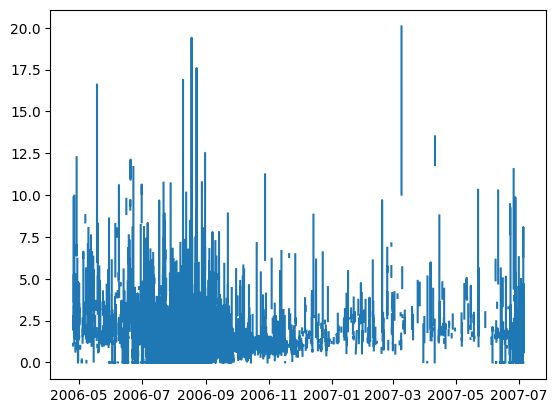

In [437]:
plt.plot(chrono, draft_)

## Average

In [439]:
# # number of observations per day
# if '5min' in ifile:
#     n_measure = 288
# elif '7min' in ifile:
#     n_measure = 206
# elif '8min' in ifile:
#     n_measure = 179
# elif '10min' in ifile:
#     n_measure = 144

In [440]:
# #daily
# draft_m = np.nanmean(draft_.reshape(-1,n_measure),axis=1)
# draft_md = np.nanmedian(draft_.reshape(-1,n_measure),axis=1)

# draft_std = np.nanstd(draft_.reshape(-1,n_measure),axis=1)
# draft_min = np.nanmin(draft_.reshape(-1,n_measure),axis=1)
# draft_max = np.nanmax(draft_.reshape(-1,n_measure),axis=1)

In [441]:
chrono_date_clean

array([datetime.date(2006, 4, 25), datetime.date(2006, 4, 25),
       datetime.date(2006, 4, 25), ..., datetime.date(2007, 7, 5),
       datetime.date(2007, 7, 5), datetime.date(2007, 7, 5)], dtype=object)

In [445]:
draft_m, draft_std, draft_min, draft_max, chrono_cl = daily_average(chrono_date_clean, draft_)

/tmp/ipykernel_121179/427464575.py:21: RuntimeWarning: Mean of empty slice
  avr.append(np.nanmean(draft[ii:ii+ni]))
/tmp/ipykernel_121179/427464575.py:23: RuntimeWarning: All-NaN slice encountered
  mini.append(np.nanmin(draft[ii:ii+ni]))
/tmp/ipykernel_121179/427464575.py:24: RuntimeWarning: All-NaN slice encountered
  maxi.append(np.nanmax(draft[ii:ii+ni]))


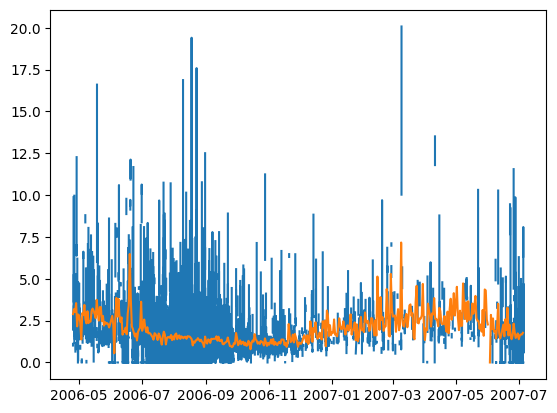

In [450]:
plt.plot(chrono, draft_)
plt.plot(chrono_cl, draft_m)
# plt.plot(chrono_daily, draft_md)

# plt.plot(chrono_daily, draft_min)
# plt.plot(chrono_daily, draft_max)

# plt.plot(chrono_daily, draft_m+draft_std, alpha=0.5)
# plt.plot(chrono_daily, draft_m-draft_std, alpha=0.5)

# Location Buoy

In [66]:
# location buoy

# surveyed latitude/longitude (also used in 2-seconds files)
# translated from degrees minutes seconds to decimal degrees with:
# https://www.fcc.gov/media/radio/dms-decimal

def get_latlon(year_buoy):

    dico_latlon = {2001: [89.550114, 66.633561],
                   2002: [89.450127, 53.633405],
                   2003: [89.383427, 46.11671],
                   2004: [89.45008, 54.316873],
                   2005: [89.250048, 64.683475],
                   2006: [89.333558, 77.116724],                   
                   2008: [89.516813, 84.366802]
                  }
    
    
    if year_buoy in dico_latlon:
        return dico_latlon[year_buoy]
    else:
        return None

In [69]:
lat, lon = get_latlon(year)

# Create daily time series

.nc files with daily:
mean sit, std, min, max, time (readable format), location (change every year)

In [438]:
def daily_average(chrono, draft):
    '''Requiere as the number of observations varies from day to day.
    
    Chrono only with valid days
    '''
       
    # Get number of obs each day
    chrono_unique, nmd = np.unique(chrono, return_counts=True)    
    
    nmd_cum = np.concatenate((np.array([0]),np.cumsum(nmd)[:-1]))    

    # average each day
    avr = []
    std = []
    mini = []
    maxi = []
    

    # [starting position:start pos + number of measure on this day]
    for ii, ni in zip(nmd_cum, nmd):
        avr.append(np.nanmean(draft[ii:ii+ni]))
        std.append(np.nanstd(draft[ii:ii+ni]))
        mini.append(np.nanmin(draft[ii:ii+ni]))
        maxi.append(np.nanmax(draft[ii:ii+ni]))
        


    return np.array(avr), np.array(std), np.array(mini), np.array(maxi), chrono_unique

In [522]:
# put all this shit in a function

def read_txt(ifile):
    '''
    '''
    encoding = 'utf-8'
    if '2006' in ifile or '2008' in ifile:
        encoding = 'iso-8859-1'
    
    with open(f'{ifile}','r', encoding=encoding) as f:
        lines = f.readlines()
        
    # data start at this line
    idx_start = np.where(np.array([s in ' #\n' for s in lines]))[0][-1] +1
    
    header_var = ['year', 'month', 'day','hour', 'min', 'sec', 'time', 'depth', 'draft'] 
    
    # read data for read
    data = np.genfromtxt(f'{ifile}', delimiter=' +', dtype='U255', skip_header=idx_start, 
                         autostrip=True, encoding=encoding)
    
    types_data = ['int', 'int', 'int', 'int', 'int', 'int']+ ['float']*3

    # array with all the lines
    arr = []
    for dt in data:
        arr += [item for item in re.split(' +', dt)]

    nlines = data.shape[0]
    bb = np.array(arr).reshape(nlines, len(types_data))  # 28

    # create dictionary from the array
    dico = {}

    for idx, (var, typecol) in enumerate(zip(header_var, types_data)):
        # format data
        if typecol == 'U12':
            typec = 'U12'
        elif typecol == 'float':
            typec = np.float64
        elif typecol == 'int':
            typec = np.int64

        dico[f'{var}'] = np.asarray(bb[:,idx], dtype=typec)
    
    return dico
        
def clean_draft(dico):
    '''dico is output from read_txt()
    
    Convert draft to sea ice thickness with the coefficient: 1.2
    '''
    draft = dico['draft']

    ids = np.where(draft!=-999)[0][0]  # idx_data_start
    ide = np.where(draft!=-999)[0][-1]  # idx_data_end

    # chrono for the whole period
    chrono = np.array([datetime.datetime(yr,mo,dy,hr,mn,sc) for yr, mo, dy, hr, mn, sc in zip(dico['year'],dico['month'],dico['day'],dico['hour'],dico['min'],dico['sec'])])

    # remove the first day and last day
    # so we have complete days

    chrono_date = np.array([dt.date() for dt in chrono])  # datetime.date() only
    first_date = (chrono[ids] + datetime.timedelta(days=1)).date()
    last_date = (chrono[ide] - datetime.timedelta(days=1)).date()
    # occurrence of first valid day
    ids_real = np.where(chrono_date==first_date)[0][0]
    # occurrence of last valid day
    ide_real = np.where(chrono_date==last_date)[0][0]
    
    
    draft_ = draft[ids_real:ide_real]
    draft_[np.where(draft_==-999)] = np.nan

    # chrono for data valid only
    chrono = np.array([datetime.datetime(yr,mo,dy,hr,mn,sc) for yr, mo, dy, hr, mn, sc in zip(dico['year'][ids_real:ide_real],dico['month'][ids_real:ide_real],dico['day'][ids_real:ide_real],dico['hour'][ids_real:ide_real],dico['min'][ids_real:ide_real],dico['sec'][ids_real:ide_real])])
    chrono_daily = np.unique(np.array([datetime.datetime(yr,mo,dy,0,0,0) for yr, mo, dy in zip(dico['year'][ids_real:ide_real],dico['month'][ids_real:ide_real],dico['day'][ids_real:ide_real])]))
    
    chrono_date_clean = np.array([dt.date() for dt in chrono]) 
    
    return  draft_*1.1, chrono_date_clean  # chrono_daily
    
    
def get_data(year:int):
    '''
    '''
        
    # globglob the file
    idir = f'/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_NPEO/{year}/ULS/'
    ifile = glob(f'{idir}Mooring*{year}*min*.txt')[0]
    
    # read .txt
    dico = read_txt(ifile)

    # clean data
    draft, chrono = clean_draft(dico)
    
    # average daily
    draft_m, draft_std, draft_min, draft_max, chrono_cl = daily_average(chrono, draft)
    lat, lon = get_latlon(year)
    
    lat, lon = np.array([lat]*len(draft_m)), np.array([lon]*len(draft_m))
    
    return draft_m, draft_std, draft_min, draft_max, lat, lon, chrono_cl
    

## loop over all years

In [523]:
fsit = []
fsit_std = []
fsit_min = []
fsit_max = []
flat = []
flon = []
fdates = []
# valid_years = []

In [524]:
# 2003 has no data due to leaking
years = [2001,2002,2004,2005,2006,2008]

In [525]:
for yr in years:
    print(yr)
    sit, sit_std, sit_min, sit_max, lat, lon, dates = get_data(yr)
    # sit, sit_std, sit_min, sit_max, lat, lon, dates = get_var(name_buoy, year=yr)
    
    # add yearly data to full timeline
    if sit is not None:
#         valid_years.append(yr)
        fsit.append(sit)
        fsit_std.append(sit_std)
        fsit_min.append(sit_min)
        fsit_max.append(sit_max)
        flat.append(lat)
        flon.append(lon)
        fdates.append(dates)

2001
2002
2004
2005
2006


/tmp/ipykernel_121179/427464575.py:21: RuntimeWarning: Mean of empty slice
  avr.append(np.nanmean(draft[ii:ii+ni]))
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_121179/427464575.py:23: RuntimeWarning: All-NaN slice encountered
  mini.append(np.nanmin(draft[ii:ii+ni]))
/tmp/ipykernel_121179/427464575.py:24: RuntimeWarning: All-NaN slice encountered
  maxi.append(np.nanmax(draft[ii:ii+ni]))


2008


In [527]:
fsit = np.concatenate(fsit, axis=0)
fsit_std = np.concatenate(fsit_std, axis=0)
fsit_min = np.concatenate(fsit_min, axis=0)
fsit_max = np.concatenate(fsit_max, axis=0)
flat = np.concatenate(flat, axis=0)
flon = np.concatenate(flon, axis=0)

In [528]:
fdates = np.concatenate(fdates, axis=0)

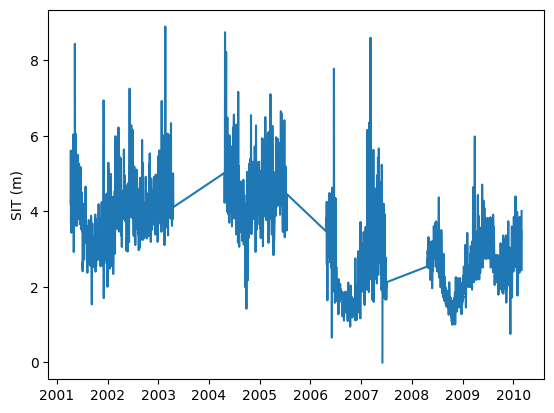

In [529]:
plt.plot(fdates, fsit)
plt.ylabel('SIT (m)');

In [472]:
print(f'Number of valid days: {fsit.shape[0]}')

Number of valid days: 2295


## Running mean

In [492]:
from src.data_preparation import running_mean as rm

In [493]:
ndays = 7
smooth_data = rm.center_running_mean(fsit, ndays, npd=1)
sit_smooth = np.array(smooth_data)

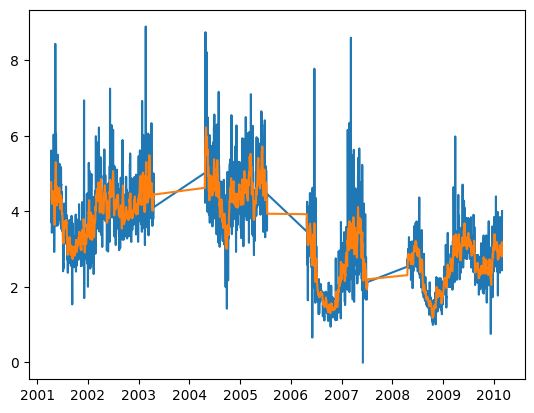

In [504]:
plt.plot(fdates, fsit)
plt.plot(fdates, sit_smooth)

## fix time

In [ ]:
# first_day = datetime.datetime.combine((chrono[ids] + datetime.timedelta(days=1)).date(), datetime.time(0,0))


In [540]:
fdates

array([datetime.date(2001, 4, 11), datetime.date(2001, 4, 12),
       datetime.date(2001, 4, 13), ..., datetime.date(2010, 2, 27),
       datetime.date(2010, 2, 28), datetime.date(2010, 3, 1)],
      dtype=object)

In [545]:
fdt = [datetime.datetime.combine(dt, datetime.time(0,0))    for dt in fdates]

## Save netcdf

In [548]:
odir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_NPEO/netcdf/'

In [547]:
osit = xr.DataArray(fsit, 
                coords={'time': fdt}, 
                dims=["time"],
                attrs={'name':'sit',
                       'long_name':'mean sea ice thickness',
                       'unit':'m',
                      })

In [553]:
osit_std = xr.DataArray(fsit_std, 
                coords={'time': fdt}, 
                dims=["time"],
                attrs={'name':'sit_std',
                       'long_name':'sea ice thickness standard deviation',
                       'unit':'m',
                      })

In [554]:
osit_min = xr.DataArray(fsit_min, 
                coords={'time': fdt}, 
                dims=["time"],
                attrs={'name':'sit_min',
                       'long_name':'minimum sea ice thickness',
                       'unit':'m',
                      })

In [555]:
osit_max = xr.DataArray(fsit_max, 
                coords={'time': fdt}, 
                dims=["time"],
                attrs={'name':'sit_max',
                       'long_name':'maximum sea ice thickness',
                       'unit':'m',
                      })

In [556]:
olat = xr.DataArray(flat, 
                coords={'time': fdt}, 
                dims=["time"],
                attrs={'name':'latitude',
                       'unit':'North'
                      })

In [557]:
olon = xr.DataArray(flon, 
                coords={'time': fdt}, 
                dims=["time"],
                attrs={'name':'longitude',
                       'unit':'East'
                      })

In [558]:
ods = xr.Dataset(data_vars={'sit':    osit,
                            'sit_std':osit_std,
                            'sit_min':osit_min,
                            'sit_max':osit_max,
                            'lat':olat,
                            'lon':olon
                           },
                   attrs=dict(
                       long_name='Daily average from 5-10min observations',
                       description='Timeseries of SIT from ULS NPEO',
                       years=f'from {years[0]} until {years[-1]}',
                       mooring=f'NPEO',
                       author='Leo Edel, Nersc',
                       project='TARDIS',
                       date=f'{datetime.date.today()}')
                  )

In [559]:
ods

<xarray.Dataset>
Dimensions:  (time: 2295)
Coordinates:
  * time     (time) datetime64[ns] 2001-04-11 2001-04-12 ... 2010-03-01
Data variables:
    sit      (time) float64 4.21 5.614 3.701 5.572 ... 3.404 2.441 3.179 4.012
    sit_std  (time) float64 3.287 3.75 2.519 3.646 ... 2.675 2.111 2.172 2.544
    sit_min  (time) float64 0.132 1.72 1.525 1.914 ... 0.5508 0.3408 0.5928 1.03
    sit_max  (time) float64 18.55 19.96 17.52 17.4 ... 13.73 15.31 16.11 16.03
    lat      (time) float64 89.55 89.55 89.55 89.55 ... 89.52 89.52 89.52 89.52
    lon      (time) float64 66.63 66.63 66.63 66.63 ... 84.37 84.37 84.37 84.37
Attributes:
    long_name:    Daily average from 5-10min observations
    description:  Timeseries of SIT from ULS NPEO
    years:        from 2001 until 2008
    mooring:      NPEO
    author:       Leo Edel, Nersc
    project:      TARDIS
    date:         2023-09-11

In [560]:
filename = f'uls_NPEO_{years[0]}_{years[-1]}.nc'

In [561]:
ofile = save_name.check(f"{odir}", filename)
ods.to_netcdf(f'{odir}{ofile}')
print(f'Netcdf saved as: {odir}{ofile}')

Netcdf saved as: /scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_NPEO/netcdf/uls_NPEO_2001_2008.nc


# Plot time series

In [562]:
import matplotlib.pyplot as plt

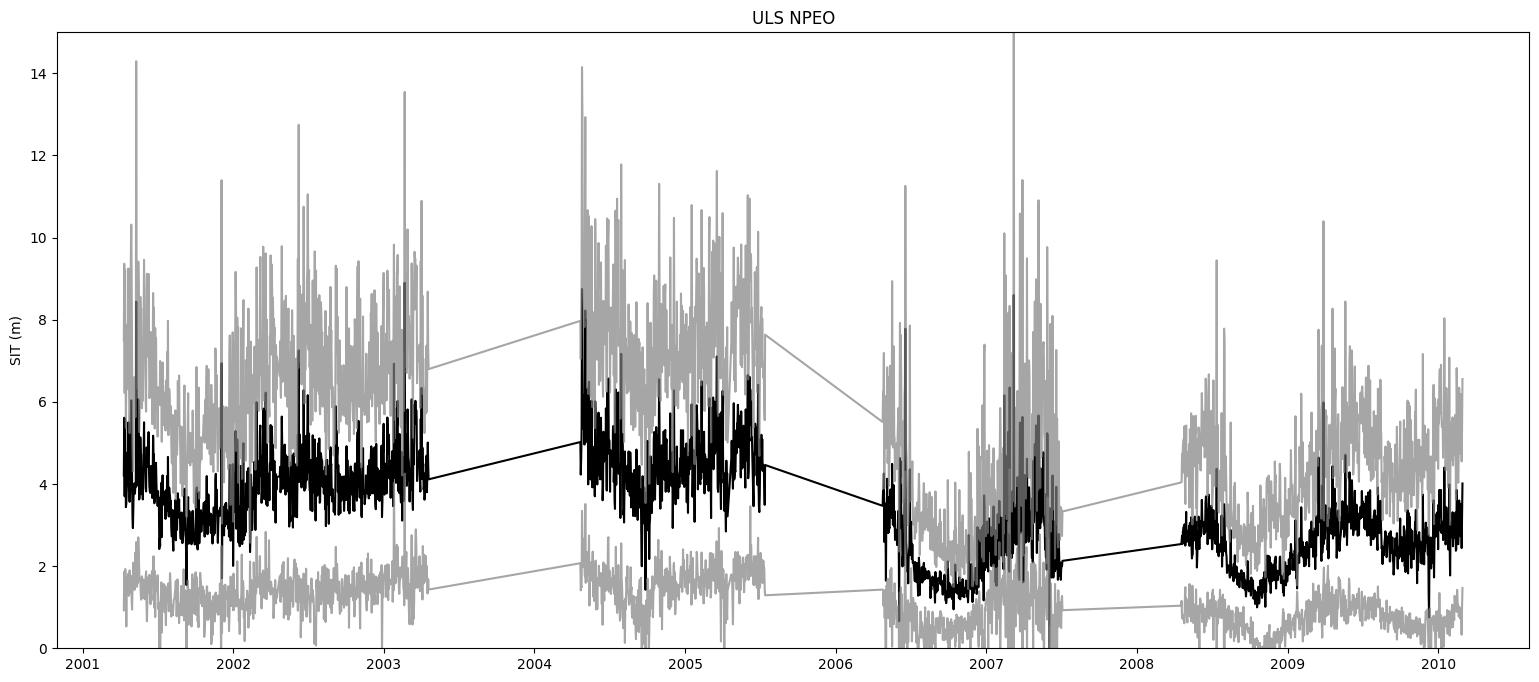

In [568]:
plt.figure(figsize=(19,8))

plt.plot(fdates, fsit, 'k', ls='-')
plt.plot(fdates, fsit+fsit_std, c='grey', alpha=0.7)
plt.plot(fdates, fsit-fsit_std, c='grey', alpha=0.7)

plt.ylim([0,15])
plt.ylabel('SIT (m)');
plt.title(f'ULS NPEO');